In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [2]:
labels = pd.read_csv('./data/train_labels.csv', nrows=200)
print(labels['label'].value_counts())
labels.head()

label
0    118
1     82
Name: count, dtype: int64


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


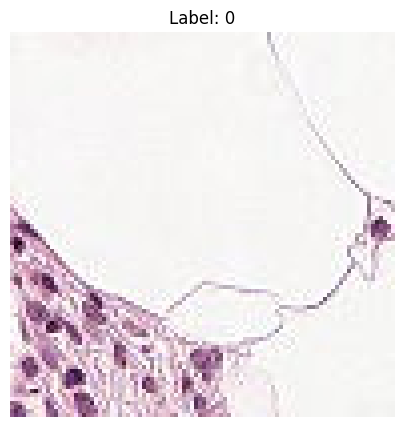

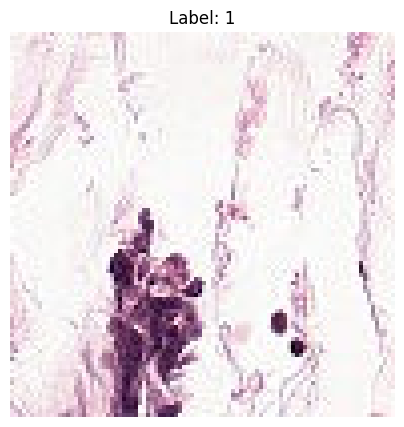

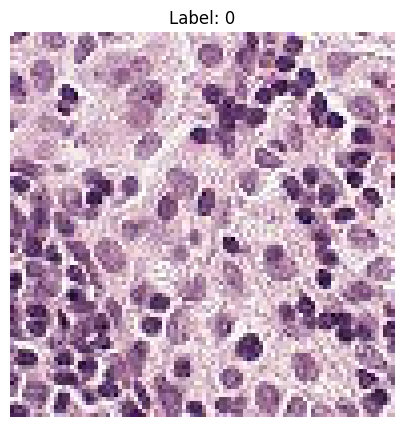

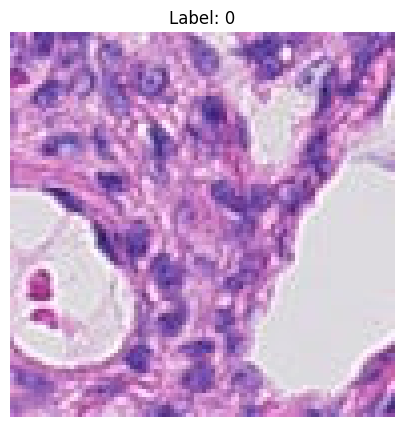

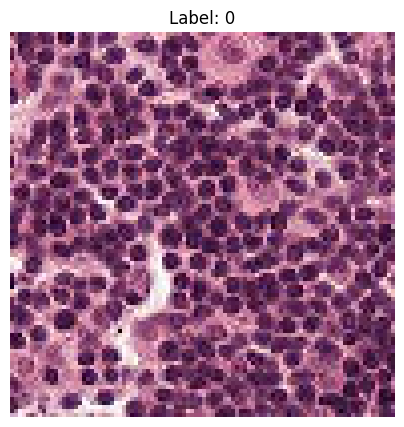

In [3]:
for i in range(5):
    # Load image
    img_id = labels.iloc[i, 0]
    img = cv2.imread(f'./data/train/{img_id}.tif')

    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display image and label
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f'Label: {labels.iloc[i, 1]}')
    plt.axis('off')
    plt.show()

In [4]:
img_sizes = []
for img_id in labels['id']:
    img = cv2.imread(f'./data/train/{img_id}.tif')
    img_sizes.append(img.shape[:2])
avg_img_size = np.mean(img_sizes, axis=0)
print(f"Multiple image sizes?\n\t* {True if len(set(img_sizes)) > 1 else False}")
print(f'Image Size: {avg_img_size}')

Multiple image sizes?
	* False
Image Size: [96. 96.]


In [5]:
from scipy.ndimage import convolve

# Initialize an array to store the average variances so we can plot.
avg_variances = []

for size in range(2, 8):
    # print(f'Processing convolution size: {size}')
    variances = []
    kernel = np.ones((size, size, 3), dtype=np.float32) / (size * size)

    for img_id in labels['id']:
        img = cv2.imread(f'./data/train/{img_id}.tif')
        convolved_img = convolve(img, kernel)
        variance = np.var(convolved_img)
        variances.append(variance)
        img_var = np.var(convolved_img)
        variances.append(img_var)

    size_var = np.mean(variances)
    avg_variances.append(size_var)
    # print(f'\tVariance {size_var:.4f}')

# Find the convolution size with the highest variance.
optimal_size = np.argmax(avg_variances) + 2  # +2 because we started from size 2.
print(f'Optimal convolution size: {optimal_size}')


Optimal convolution size: 3


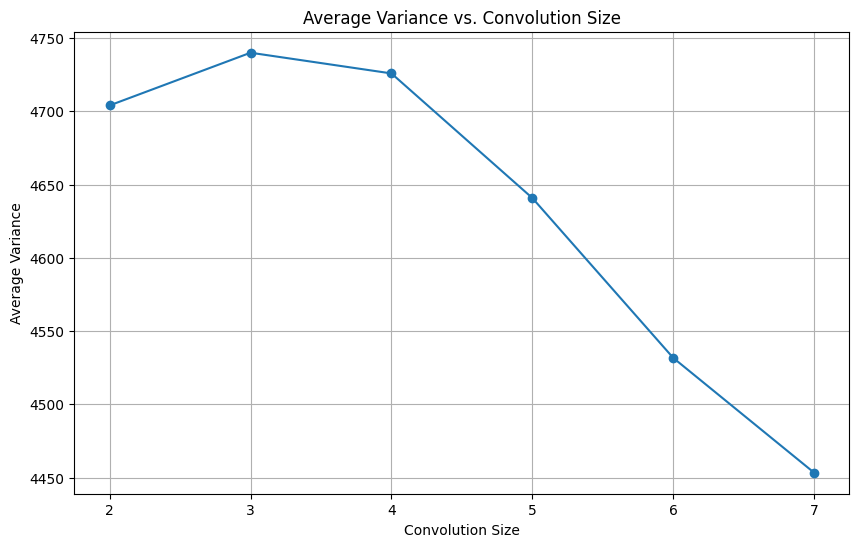

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 8), avg_variances, marker='o')
plt.title('Average Variance vs. Convolution Size')
plt.xlabel('Convolution Size')
plt.ylabel('Average Variance')
plt.grid(True)
plt.show()

In [7]:
import torch

if torch.cuda.is_available():
    print(torch.cuda.is_available())
    torch.device("cuda")

True


In [8]:
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


RANDOM_STATE = 35

class MriImages(Dataset):
    def __init__(self, labels, img_dir, transform=None):
        self.labels = labels
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        # label = self.labels.iloc[idx, 1]
        label = np.array([self.labels.iloc[idx, 1]])

        if self.transform:
            image = self.transform(image)
            # Change from (B,C,H,W) to (B,H,W,C) for PyTorch vs Keras...
            image = image.permute((1,2,0))
            
        return image, label

# Load labels and convert to filenames.
all_labels = pd.read_csv('data/train_labels.csv')
all_labels['id'] = all_labels['id'].apply(lambda x: f'{x}.tif')

# Split labels into training and validation sets.
train_labels, valid_labels = train_test_split(all_labels, test_size=0.15, random_state=RANDOM_STATE)

# Transform raw image.
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45), 
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5, True)
])

# Try grayscale - v4
# transform = transforms.Compose([
#     transforms.Resize((96, 96)),
#     transforms.Grayscale(num_output_channels=3),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,)),
#     transforms.RandomRotation([90, 180]),
# ])

# Create datasets/loaders.
train_dataset = MriImages(labels=train_labels, img_dir='./data/train', transform=transform)
valid_dataset = MriImages(labels=valid_labels, img_dir='./data/train', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True, pin_memory=True)

In [9]:
from keras.src.optimizers import SGD
from keras import regularizers, Input
from keras import Sequential
from keras.api.metrics import BinaryAccuracy
from keras.api.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


CONV_SIZE = (3,3)

model = Sequential()
model.add(Input((96, 96, 3)))

model.add(Conv2D(32, CONV_SIZE, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32*4, CONV_SIZE, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32*8, CONV_SIZE, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Add regularization - v2.
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())

# Add dropout layer - v3.
model.add(Dropout(0.5))

# Actually classification here.
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[BinaryAccuracy()])
# model.compile(optimizer='adamw', loss='binary_crossentropy', metrics=[BinaryAccuracy()])
# sgd = SGD(learning_rate=0.01, momentum=0.9)
# model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=[BinaryAccuracy()])

if torch.cuda.is_available():
    model.to("cuda")

In [10]:
model.fit(train_loader, validation_data=valid_loader, epochs=20)

Epoch 1/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 255s 174ms/step - binary_accuracy: 0.7976 - loss: 1.2479 - val_binary_accuracy: 0.8257 - val_loss: 0.6174
Epoch 2/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 201s 137ms/step - binary_accuracy: 0.8498 - loss: 0.5880 - val_binary_accuracy: 0.8577 - val_loss: 0.5108
Epoch 3/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 193s 132ms/step - binary_accuracy: 0.8615 - loss: 0.5275 - val_binary_accuracy: 0.8361 - val_loss: 0.5529
Epoch 4/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 195s 134ms/step - binary_accuracy: 0.8622 - loss: 0.5103 - val_binary_accuracy: 0.8455 - val_loss: 0.5803
Epoch 5/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 195s 133ms/step - binary_accuracy: 0.8665 - loss: 0.5003 - val_binary_accuracy: 0.8628 - val_loss: 0.4758
Epoch 6/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 194s 133ms/step - binary_accuracy: 0.8675 - loss: 0.4839 - val_binary_accuracy: 0.8558 - val_loss: 0.4915
Epoch 7/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 196s 134ms/step - binary_accuracy: 0.8687 - loss: 0.4823 - val_binary_

In [11]:
model.save("./artifact/conv-2d-x2-adam.h5")

2024-06-10 12:43:42.757185: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 12:43:42.927477: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 12:43:43.666744: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [45]:
import os
import glob
import pandas as pd

TEST_DATA = './data/test'

test_transform = transforms.Compose([transforms.Resize(96), transform])

def predict_label(filename: str) -> int:
    """Given a filename, load the image and predict the label."""
    img_path = os.path.join("./data/test", filename)
    image = Image.open(img_path).convert('RGB')
    image = test_transform(image)
    image = image.permute((1,2,0))
    image = image.unsqueeze(0)
    label = model(image)    
    return (label >= 0.5).int().item()

def get_tif_paths(directory) -> pd.DataFrame:
    tif_files = glob.glob(os.path.join(directory, '*.tif'))
    tif_paths_and_basenames = [(os.path.abspath(path), os.path.splitext(os.path.basename(path))[0]) for path in tif_files]
    df = pd.DataFrame(tif_paths_and_basenames, columns=['abspath', 'id'])
    return df

df = get_tif_paths(TEST_DATA)
print(f"{df.shape[0]} rows to test")
df.head(5)

57458 rows to test


,abspath,id
0,/home/william/Documents/00 - MSCS at CU Boulde...,de1fcbc3315ce75fe31a49df327d8c3615f15e7a
1,/home/william/Documents/00 - MSCS at CU Boulde...,560f3956f5f665d082de68bf4656e2bf96c3962a
2,/home/william/Documents/00 - MSCS at CU Boulde...,2de42bbe3dc2a0172a4de56d4fa5b06dac03c219
3,/home/william/Documents/00 - MSCS at CU Boulde...,2ce68cbb3145e031b5e71e62ebf210a4a927a098
4,/home/william/Documents/00 - MSCS at CU Boulde...,dcb41f5d341ba50a5bdb323310c4b1833833fa48


In [51]:
from IPython.display import clear_output

torch.cuda.empty_cache()

preds = []
count_zeroes = 0
count_ones = 0

for i, (_, abspath, id_) in enumerate(df.itertuples()):
    pred = predict_label(abspath)
    preds.append((id_, pred))

    if pred == 0:
        count_zeroes += 1
    elif pred == 1:
        count_ones += 1

    if (i+1) % 500 == 0:
        clear_output()
        print(f"Iteration: {i+1} / {df.shape[0]}")
        print(f"Zeroes found: {count_zeroes} ({(count_zeroes / (i+1)) * 100:.2f}%)")
        print(f"Ones found: {count_ones} ({(count_ones / (i+1)) * 100:.2f}%)")

df_pred = pd.DataFrame(preds, columns=['id', 'label'])
df_pred.head(5)

Iteration: 57000
Zeroes found: 36281 (63.65%)
Ones found: 20719 (36.35%)


,id,label
0,de1fcbc3315ce75fe31a49df327d8c3615f15e7a,1
1,560f3956f5f665d082de68bf4656e2bf96c3962a,0
2,2de42bbe3dc2a0172a4de56d4fa5b06dac03c219,0
3,2ce68cbb3145e031b5e71e62ebf210a4a927a098,1
4,dcb41f5d341ba50a5bdb323310c4b1833833fa48,1


In [52]:
df_pred.to_csv('./artifact/submission.csv', columns=['id', 'label'], index=False)

In [53]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,906,309 (91.20 MB)

 Trainable params: 7,968,577 (30.40 MB)

 Non-trainable params: 576 (2.25 KB)

 Optimizer params: 15,937,156 (60.80 MB)